# Using an Artificial Neural Network for the Task of Road Following

## Introduction

Autonomous driving is getting increased attention nowadays. While it was a pure research
topic in the 1980s, today there are many companies which develop self-driving cars. The algorithms
used by autonomous driving systems can vary widely from traditional vision and robotic techniques to
artificial neural networks. Since autonomous driving is a problem with a lot of noise and variability
in the input data it is hard to optimize traditional techniques to perform well. That is why
researchers developed artificial neural networks for the task of road following in the 1980s.
This work is based on the paper "ALVINN: An Autonomous Land Vehicle in a Neural Network" by
Pomerleau et al. and explores how a neural network can be used for the task of road following.
The neural network gets an image of a street as input and outputs a steering wheel angle. This is called
an end-to-end steering system which should not be confused with semantic segmentation or object
detection frequently used by autonomous driving systems nowadays.

## The Idea

This section introduces the neural network that was used by Pomerleau et al. in the paper ALVINN for the task of road following. 

The network is a 3-layer back-propagation network that uses the data of a camera and laser range finder as an input and outputs the steering angle in which the vehicle should drive. The camera input has a dimension of 30x32 pixels and only the blue color cannel is used. The blue cannel is choosen because it provides the best contrast between the road and the neighbouring environment. The laser range finder input has a dimension of 8x32 pixels where each pixel indicates the proximity of objects in front of the car. This information can be used by the neural network to avoid obstacles on the road. Additionally the network has a road intensity feedback unit which outputs whether the road is lighter than the surrounding environment or not. This output is fed with the next input into the neural network. The input data is flattend into a vector and then fed to the input layer. The exact dimensions and the structure described here can be seen in the following graphic.

![Neural Network]()

The output of the neural network are 45 units that describe the steering wheel angel plus one unit for the road insensity feedback. Since the output is no continues value the steering angles have to be encoded in an appropriated manner. This is done by assigning each angle to the corresponding output unit. The unit in the middle means thereby driving straight ahead and the units to the left and the right mean steering to the left or to the right. The values for the output units are zero except for a "hill" where the angel is assigned to. The exact values are 0.10, 0.32, 0.61, 0.89, 1.00, 0.89, 0.61, 0.32, 0.10 and are centered around angle's output unit. A graphical representation can be seen in the data preprocessing section below.

### Data Set

Training a neural network requires massiv amount of labeled training samples. Since collecting such a data set is time consuming, the authors of the ALVINN paper used simulated road images to train their neural network. They generated 1200 samples with various camera orientations, lighting conditions and noise levels.

### Training

The training of the neural network is executed through back-propagation using the 1200 simulated road images. The optimization consists of two phases. In the first phase, the road intensity unit is given random values as input. The goal hereby is that the road intensity output unit does not just copy the input value but deduce it from the acutal image. In the second phase after the network learned this relationship the road intensity input unit is given real brightness values from the previous image.

The authors of the ALVINN paper stated that after 40 epochs of training the network was able to predict the correct steering angle within two units in about 90% of newly created simulated road images. Furthermore the authors tested the neural network in the NAVLAB vehicle which is a modified Chevy van with multiple computers, a camera and a laser range finder. The neural network was able to steer the vehicle at a speed of 1/2 meter per second on a 400 meter path over the CMU campus. The results where comparable to the best traditional vision-based road following algorithm at CMU but this algorithm needed months of manual parameter tuning. Whereas the neural network was able to learn this in half an hour once the data set was created.

## Implementation

This work implements a version of the ALVINN neural network using Tensorflow and real road images from an openly available data set. Since there was no laser range finder data and no label for the road intensity unit, this implementation is only based on camera images. This is no problem for showing the general idea of the ALVINN paper. The authors concluded anyway that the laser range finder is not important as long as the vehicle is not driving off-road. Another difference is that the data set used in this work has images of the size 60x64 and not 30x32. Later on there is a comparision how the network performs with the higher resultion compared to the lower one from the paper.

In the following the data set is loaded, preprocessed and split into train and test data. Afterwards the neural network is trained and evaluated on the test data.

In [1]:
# imports and configurations
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

project_path = "/opt/project/"

import sys
sys.path.insert(0, project_path)

In [2]:
# load data set
import h5py

X = []
y = []
with h5py.File(f"{project_path}data/track_data_2.h5", "r") as f:
    for image, label in zip(f['images'], f['angles']):
        X.append(image)
        y.append(label)

X = np.asarray(X, dtype=np.float32)
y = np.asarray(y, dtype=np.float32)

print(f"Data set size: {len(X)}")
print(f"Image size: {X[0].shape}")

Data set size: 2000
Image size: (60, 64)


In [3]:
# visualize the data set
from visualization import visualize_angle_in_gif

visualize_angle_in_gif(X, y, fn="training_data_visualization")

The following GIF shows the steering angle for each image displayed as
a green line.

![Training data visualization](graphic/training_data_visualization.gif)

Images minimal pixel value: 7.0
Images maximal pixel value: 255.0

Minimal steering angle: -165.42462158203125
Maximal steering angle: 23.003211975097656


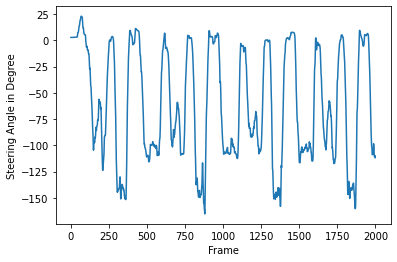

In [4]:
# explore the data set

print(f"Images minimal pixel value: {X.min()}")
print(f"Images maximal pixel value: {X.max()}")
print()
print(f"Minimal steering angle: {y.min()}")
print(f"Maximal steering angle: {y.max()}")

plt.plot(y)
plt.ylabel("Steering Angle in Degree")
plt.xlabel("Frame");

## Data Set Preprocessing

Before the neural network can be trained, the input data has to be normalized.
This is done by using Min-Max normalization with a minimum of 0.0 and a maximum
of 255.0.

Furthermore, each steering wheel angle has to be assigned to one of 45 bins.
This is not simply done by one-hot encoding the assigned bin but by encoding
the angle with the following values 0.1, 0.32, 0.61, 0.89, 1.0, 0.89, 0.61, 0.32, 0.1.
The target bin is the one with the 1.0 value and the ones left and right
get the other values.

Training data size: 1400


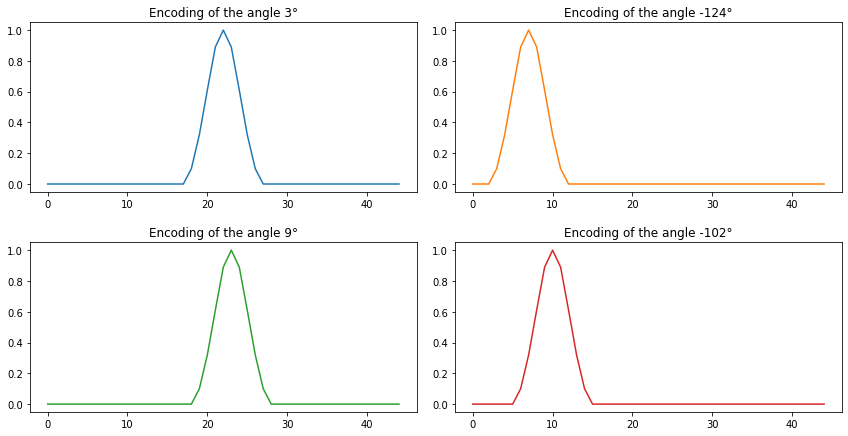

In [5]:
# data preprocessing
from sklearn.utils import shuffle

import utils

# normalize the images
X_normalized = X / 255.0

# encode the angles
y_encoded = utils.encode_angle(y, output_bins=45)

# visualize encoding
fig, axs = plt.subplots(2, 2, figsize=(12,6))
fig.tight_layout()
fig.subplots_adjust(hspace=.3, wspace=.1)
axs[0, 0].plot(y_encoded[0])
axs[0, 0].set_title(f"Encoding of the angle {round(y[0])}°")
axs[0, 1].plot(y_encoded[300], 'tab:orange')
axs[0, 1].set_title(f"Encoding of the angle {round(y[300])}°")
axs[1, 0].plot(y_encoded[50], 'tab:green')
axs[1, 0].set_title(f"Encoding of the angle {round(y[50])}°")
axs[1, 1].plot(y_encoded[1000], 'tab:red')
axs[1, 1].set_title(f"Encoding of the angle {round(y[1000])}°")

# split data into train (70%) and test data (30%)
train_data_size = round(len(X) * 0.7)
print(f"Training data size: {train_data_size}")

X_train = X_normalized[:train_data_size]
y_train = y_encoded[:train_data_size]

# shuffle data before training
X_train, y_train = shuffle(X_train, y_train, random_state=1)

X_test = X_normalized[train_data_size:]
y_test = y_encoded[train_data_size:]


In [6]:
# initialize tensorflow
import tensorflow as tf
print(f"Tensorflow version {tf.__version__}")
print(f"GPU: {tf.config.list_physical_devices('GPU')}")
tf.random.set_seed(1)
tf.config.experimental_run_functions_eagerly(True)

# model definition
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(60, 64)),
    tf.keras.layers.Dense(3840, activation=None),
    tf.keras.layers.Dense(29, activation=tf.keras.activations.sigmoid),
    tf.keras.layers.Dense(45, activation=None)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[utils.alvinn_accuracy]
              )

Tensorflow version 2.5.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [7]:
# train the neural network
history = model.fit(X_train, y_train, epochs=100)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0835 - alvinn_accuracy: 0.2164
Epoch 2/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0704 - alvinn_accuracy: 0.3475
Epoch 3/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0678 - alvinn_accuracy: 0.3549
Epoch 4/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0656 - alvinn_accuracy: 0.3575
Epoch 5/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0636 - alvinn_accuracy: 0.3778
Epoch 6/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0608 - alvinn_accuracy: 0.4718
Epoch 7/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0575 - alvinn_accuracy: 0.5215
Epoch 8/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0554 - alvinn_accuracy: 0.5260
Epoch 9/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0534 - alvinn_accuracy: 0.5417
Epoch 10/100
44/44 [=================

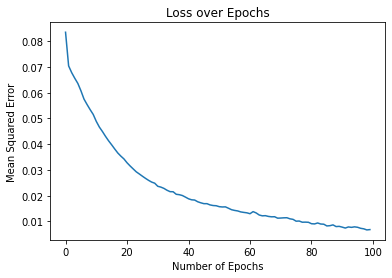

In [8]:
plt.plot(history.history["loss"])
plt.title("Loss over Epochs")
plt.ylabel("Mean Squared Error")
plt.xlabel("Number of Epochs");

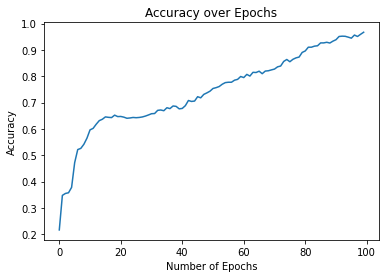

In [9]:
    plt.plot(history.history["alvinn_accuracy"])
    plt.title("Accuracy over Epochs")
    plt.ylabel("Accuracy")
    plt.xlabel("Number of Epochs");

19/19 [==============================] - 0s 8ms/step - loss: 0.0108 - alvinn_accuracy: 0.8914


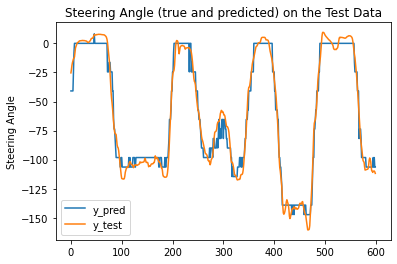

In [10]:
# testing and visualization
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

y_pred_degree = utils.decode_angle(y_pred, output_bins=45)
y_test_degree = y[train_data_size:]

plt.plot(y_pred_degree, label="y_pred")
plt.plot(y_test_degree, label="y_test")
plt.legend()
plt.title("Steering Angle (true and predicted) on the Test Data")
plt.ylabel("Steering Angle");

In [11]:
# visualize the performance in a video

visualize_angle_in_gif(X[train_data_size:], y_test_degree, y_pred_degree, "test_data_visualization")

![test data visualization](graphic/test_data_visualization.gif)

## Exploring Different Parameters

This section analyises the effects of the input size and the number of bins for the steering angle on the prediction performance.

In the original paper the input images have the size 30x32. The next cell analyzes what effect the smaller images have on the algorithm performance.

---- Training ----
Epoch 1/100
10/44 [=====>........................] - ETA: 0s - loss: 0.1822 - alvinn_accuracy: 0.1094

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


44/44 [==============================] - 1s 12ms/step - loss: 0.1006 - alvinn_accuracy: 0.2209
Epoch 2/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0703 - alvinn_accuracy: 0.2457
Epoch 3/100
44/44 [==============================] - 1s 11ms/step - loss: 0.0673 - alvinn_accuracy: 0.3795
Epoch 4/100
44/44 [==============================] - 1s 11ms/step - loss: 0.0645 - alvinn_accuracy: 0.4415
Epoch 5/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0619 - alvinn_accuracy: 0.4496
Epoch 6/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0593 - alvinn_accuracy: 0.4688
Epoch 7/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0568 - alvinn_accuracy: 0.4979
Epoch 8/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0544 - alvinn_accuracy: 0.5043
Epoch 9/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0521 - alvinn_accuracy: 0.5140
Epoch 10/100
44/44 [=============================

44/44 [==============================] - 0s 11ms/step - loss: 0.0070 - alvinn_accuracy: 0.9545
Epoch 78/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0070 - alvinn_accuracy: 0.9557
Epoch 79/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0069 - alvinn_accuracy: 0.9560
Epoch 80/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0068 - alvinn_accuracy: 0.9586
Epoch 81/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0067 - alvinn_accuracy: 0.9560
Epoch 82/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0064 - alvinn_accuracy: 0.9614
Epoch 83/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0065 - alvinn_accuracy: 0.9616
Epoch 84/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0065 - alvinn_accuracy: 0.9628
Epoch 85/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0066 - alvinn_accuracy: 0.9586
Epoch 86/100
44/44 [=====================

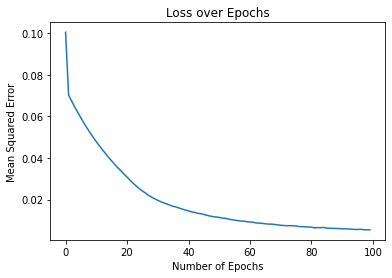

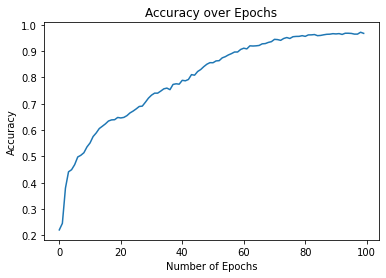

---- Testing ----
11/19 [================>.............] - ETA: 0s - loss: 0.0121 - alvinn_accuracy: 0.8636

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


19/19 [==============================] - 0s 10ms/step - loss: 0.0108 - alvinn_accuracy: 0.8964


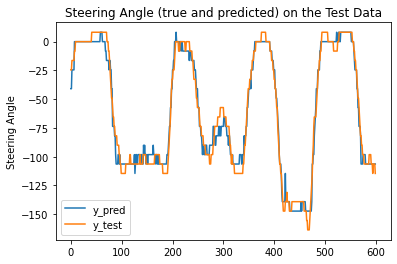

In [12]:
from trainer import train_and_evaluate

train_and_evaluate(input_size=(30,32), output_bins=45)

![Test with smaller input size](graphic/visualization_ReferenceDataSet_100_(30,32)_45.gif)

---- Training ----
Epoch 1/100
 9/44 [=====>........................] - ETA: 0s - loss: 0.0766 - alvinn_accuracy: 0.0625   

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


44/44 [==============================] - 1s 14ms/step - loss: 0.0585 - alvinn_accuracy: 0.0518
Epoch 2/100
44/44 [==============================] - 1s 16ms/step - loss: 0.0530 - alvinn_accuracy: 0.0400
Epoch 3/100
44/44 [==============================] - 1s 14ms/step - loss: 0.0523 - alvinn_accuracy: 0.1392
Epoch 4/100
44/44 [==============================] - 1s 15ms/step - loss: 0.0513 - alvinn_accuracy: 0.1307
Epoch 5/100
44/44 [==============================] - 1s 15ms/step - loss: 0.0501 - alvinn_accuracy: 0.1863
Epoch 6/100
44/44 [==============================] - 1s 15ms/step - loss: 0.0495 - alvinn_accuracy: 0.2322
Epoch 7/100
44/44 [==============================] - 1s 15ms/step - loss: 0.0480 - alvinn_accuracy: 0.2798
Epoch 8/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0469 - alvinn_accuracy: 0.3149
Epoch 9/100
44/44 [==============================] - 1s 15ms/step - loss: 0.0460 - alvinn_accuracy: 0.3217
Epoch 10/100
44/44 [=============================

44/44 [==============================] - 1s 12ms/step - loss: 0.0171 - alvinn_accuracy: 0.6619
Epoch 78/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0173 - alvinn_accuracy: 0.6496
Epoch 79/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0172 - alvinn_accuracy: 0.6496
Epoch 80/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0170 - alvinn_accuracy: 0.6544
Epoch 81/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0172 - alvinn_accuracy: 0.6442
Epoch 82/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0169 - alvinn_accuracy: 0.6411
Epoch 83/100
44/44 [==============================] - 1s 12ms/step - loss: 0.0170 - alvinn_accuracy: 0.6409
Epoch 84/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0171 - alvinn_accuracy: 0.6600
Epoch 85/100
44/44 [==============================] - 1s 13ms/step - loss: 0.0168 - alvinn_accuracy: 0.6539
Epoch 86/100
44/44 [=====================

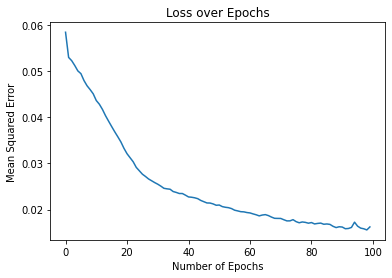

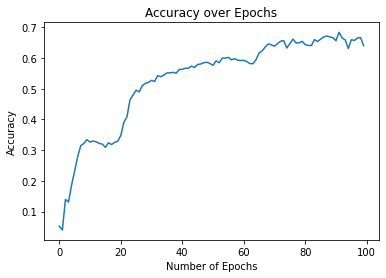

---- Testing ----
19/19 [==============================] - 0s 8ms/step - loss: 0.0169 - alvinn_accuracy: 0.6129


/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


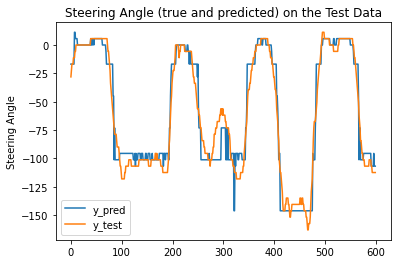

In [13]:
train_and_evaluate(input_size=(60,64), output_bins=65)

![Test with more output bins](graphic/visualization_ReferenceDataSet_100_(60,64)_65.gif)

## Discussion

- strength
    - less susceptible to noise
    - easily assimilate multiple sensors
    - easy and fast to develop ones the data set is available => no parameter tuning
- weakness
    - if it is used in conditions that where not represented in the training data
    the network will perform poorly most likely
    - dealing with road forks

## Training on a Real World Data

This section trains and tests the performance of the ALVINN neural network on real world data. This data set was created by [comma.ai](https://research.comma.ai/).

In [14]:
from data_set import CommaAiDataSet

ds = CommaAiDataSet()
ds.normalize_steering_angle()
visualize_angle_in_gif(ds.X, ds.y, fn="commaai_data_set")

(18177, 3, 160, 320)
X shape: (12200, 160, 320)
y shape: (12200,)


Visualization of the comma.ai data set in full resolution. The network will be trained with images resized to 60x64.

![Comma Ai Data Set](graphic/commaai_data_set.gif)

(18177, 3, 160, 320)
X shape: (12200, 160, 320)
y shape: (12200,)
---- Training ----
Epoch 1/30
 10/229 [>.............................] - ETA: 3s - loss: 0.0647 - alvinn_accuracy: 0.4719

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


229/229 [==============================] - 4s 15ms/step - loss: 0.0382 - alvinn_accuracy: 0.8648
Epoch 2/30
229/229 [==============================] - 4s 16ms/step - loss: 0.0186 - alvinn_accuracy: 0.8620
Epoch 3/30
229/229 [==============================] - 3s 14ms/step - loss: 0.0083 - alvinn_accuracy: 0.8341
Epoch 4/30
229/229 [==============================] - 4s 16ms/step - loss: 0.0066 - alvinn_accuracy: 0.9039
Epoch 5/30
229/229 [==============================] - 4s 16ms/step - loss: 0.0063 - alvinn_accuracy: 0.9059
Epoch 6/30
229/229 [==============================] - 3s 15ms/step - loss: 0.0061 - alvinn_accuracy: 0.9078
Epoch 7/30
229/229 [==============================] - 4s 16ms/step - loss: 0.0058 - alvinn_accuracy: 0.9112
Epoch 8/30
229/229 [==============================] - 3s 12ms/step - loss: 0.0056 - alvinn_accuracy: 0.9224
Epoch 9/30
229/229 [==============================] - 3s 15ms/step - loss: 0.0052 - alvinn_accuracy: 0.9355
Epoch 10/30
229/229 [==================

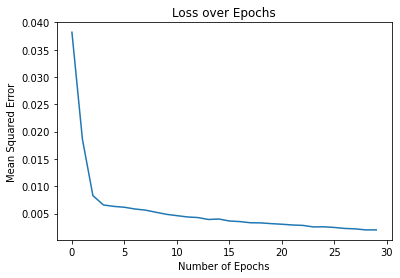

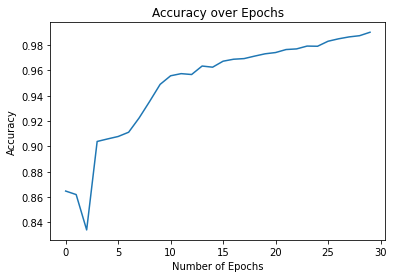

---- Testing ----
  9/153 [>.............................] - ETA: 1s - loss: 0.0070 - alvinn_accuracy: 0.8819

/usr/local/lib/python3.6/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


153/153 [==============================] - 1s 8ms/step - loss: 0.0142 - alvinn_accuracy: 0.8491


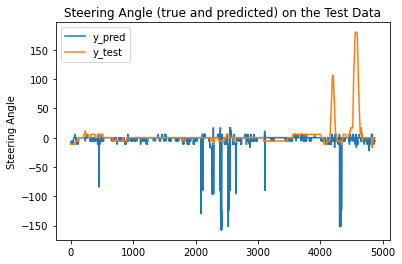

In [15]:
train_and_evaluate(ds=CommaAiDataSet(), epochs=30, input_size=(60, 64), output_bins=65)

![Test on the Comma Ai data set](graphic/visualization_CommaAiDataSet_30_(60,64)_65.gif)

## Summary

- Neural networks are a powerfull tool for autonomous driving if they are trained with
 a sufficient amount of real world data
- other network types could be tested => e.g. CNN in the NVIDIA Paper
